# Testing out function "analyse_breakthrough"

below are a series of cells dividing the function for testing. Imports neccessary in cell below.

In [2]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage.filters import uniform_filter1d

Argument declaration in function 
Need to change this depending on which files you are using (time in seconds)

In [3]:
# analyse_breakthrough variable declarations
MS_csv, flow_csv = '220803-UiO66blank-dry-22%CO2-40C.csv', '220803-UiO66blank-dry-22%CO2-40C20220803102447.txt'
T_exp, Low_conc_CO2, P_sat_H2O_bath = 313, False, 0
ms_start, flow_start, breakthrough_start = 0, 16, 4045
breakthrough_end, filter_window, filelabel = 4980, 15, '220803-UiO66blank-dry-22%CO2-40C-processed'
smoothing_start, water_outliers = {'CO2':0, 'H2O':0, 'N2':0, 'He':0}, False
water_outlier_value, spike_reduction = 2.5E-5, False
spike_reduction_parameter, extra_normalisation = 1.1, False 
relative_sensitivities, backgrounds = 'Default', 'Default'
full_output, zero_backgrounds = False, {'CO2':True, 'H2O':True, 'N2':True, 'O2':True, 'He':False} 
plot_smoothing, initial_sweep = True, 0
print(MS_csv)


220803-UiO66blank-dry-22%CO2-40C.csv


This section is used to define standard values used in code

In [4]:
MS_header_row = 26 #This is the row in the MS raw data file where the headers exist
P_atm = 1.01325E5 #Atmopsheric pressure [Pa]
P_exp = P_atm #Experimental pressure [Pa]
R = 8.314 #J/mol/K (universal gas constant)
if backgrounds == 'Default':
    background = {'N2':3.78E-9, 'He':1.44E-8, 'CO2':4.16E-11, 'O2':1.86E-10, 'H2O':3.50E-11} #Background MS values to subtract from MS data [torr]
else:
    background = backgrounds

Mw =  {'N2':28E-3, 'He':4E-3, 'CO2':44E-3, 'O2':32E-3, 'H2O':18E-3} #Molecular weights of each component [kg/mol]
max_outlet = 93.59 * 1.66667e-8 #Conversion of the max outlet flow rate in the coriolis to SI units mg/min to kg/s
max_N2 = 1.66667e-8*100*P_atm/(R*273.15) #Max flow rate in the N2 mass flow meter mol/s
max_He = 1.66667e-8*141*P_atm/(R*273.15) #Max flow rate in the He mass flow meter mol/s
coriolis_cal = {'N2':1.06, 'He':1.09, 'CO2':1.09, 'O2':1, 'H2O':1.02} #Coriolis calibration factors
#Defining relative sensitivities according to whether we select the default values or our own values
#Also defining whether the experiment is using low concs or higher concs of CO2, whih effects relative sensitivities and the CO2 mass flow rate
if relative_sensitivities == 'Default':
    if Low_conc_CO2 == True:
        max_CO2 = 1.66667e-8*0.5*P_atm/(R*273.15) #Max flow rate in the CO2 mass flow meter when its set to fluid 2 mol/s 
        RS = {'N2':1, 'He':1.92, 'CO2':0.021, 'O2':0.98, 'H2O':0.0157} #Defining mass spec relative sensitivities [-]
    
    else:
        max_CO2 = 1.66667e-8*2*P_atm/(R*273.15) #Max flow rate in the CO2 mass flow meter when its set to fluid 1 mol/s 
        RS = {'N2':1, 'He':1.92, 'CO2':0.86, 'O2':0.98, 'H2O':0.0157} #Defining mass spec relative sensitivities [-]
else: #This is if we have selected manual values of relative sensitivities
    if Low_conc_CO2 == True:
        max_CO2 = 1.66667e-8*0.5*P_atm/(R*273.15) #mol/s
        RS = relative_sensitivities #Defining mass spec relative sensitivities [-]
    
    else:
        max_CO2 = 1.66667e-8*2*P_atm/(R*273.15) #mol/s
        RS = relative_sensitivities #Defining mass spec relative sensitivities [-]
    
H2O_ratio = P_sat_H2O_bath/P_atm #this is calculation that we use to calculate the water inlet flow rate.


The below cell is used to extract the data from the csv and txt files into pandas dataframes. Then adds the respective start times onto each dataframes.
Finally they are merged together.

In [5]:
df_MS = pd.read_csv(MS_csv, header=(MS_header_row-1)).drop(['Time', 'Unnamed: 7'], axis=1) #reading the MS csv as a dataframe
df_MS.loc[:,'Time [s]'] = pd.Series([i/1000 + ms_start for i in df_MS['ms']] , index=df_MS.index) #Adding the MS start time to the times in our dataframe

df_FM = pd.read_csv(flow_csv, sep=';', names = ['Time', 'CO2', 'Time 2', 'He', 'Time 3', 'N2', 'Time 4', 'Outlet']).drop(['Time 2', 'Time 3', 'Time 4'], axis=1) #reading the flow meter csv as a dataframe
df_FM.loc[:,'Time [s]'] = pd.Series([i + flow_start for i in df_FM['Time']] , index=df_FM.index) #Adding the flow meter start time to the time in this data
#This line below is the all important step. We merge the two dataframes based on the times defined above, then we make sure its ordered in time order, and also renaming columns
df_all = pd.merge(df_MS, df_FM, on='Time [s]',how='outer', sort=True).drop(['Time', 'ms'], axis=1).rename(columns={"Nitrogen": "N2 pressure [torr]", "Water": "H2O pressure [torr]", "Carbon dioxide": "CO2 pressure [torr]", "Oxygen": "O2 pressure [torr]", "Helium": "He pressure [torr]", "CO2": "CO2 flow [%]", "He": "He flow [%]", "N2": "N2 flow [%]", "Outlet": "Outlet flow [%]"}) 

next the data is interpolated so that the random readings from MS match those of the FS. 
Dataframe is then shortened so all rows without MS readings are removed (therefore matching Coriolis to MS time readings). Instead of creating an entriely new sheet possibly it could simply ammend all 'NaN' in the existing df

In [6]:
#In this for loop we are interpolating between each time point that exists for the MS data, to get the flows from the coriolis at that time
    #In this for loop we are interpolating between each time point that exists for the MS data, to get the flows from the coriolis at that time
for comp in ['CO2', 'N2', 'He', 'Outlet']:
    label = comp + ' flow [%]'
    interpolated_flow = []
    interpolated_flow.append(float("NaN"))
    for i in range(1,len(df_all['Time [s]'])-1):
        if m.isnan(df_all[label][i]) == True:
            time_range = df_all['Time [s]'][i+1] - df_all['Time [s]'][i-1]
            time_int = df_all['Time [s]'][i] - df_all['Time [s]'][i-1]
            time_frac = time_int/time_range
            flow_before = df_all[label][i-1]
            flow_range = df_all[label][i+1] - df_all[label][i-1]
            flow_value = flow_before + flow_range*time_frac
            interpolated_flow.append(flow_value)
        else:
            interpolated_flow.append(df_all[label][i])
    interpolated_flow.append(float("NaN"))
    df_all.loc[:,'Interpolated ' + label] = pd.Series(interpolated_flow, index=df_all.index)
#Now converting the data time to the time of the breakthrough step
df_all.loc[:,'Breakthrough time [s]'] = pd.Series([i - breakthrough_start for i in df_all['Time [s]']], index=df_all.index)
#Now deleting rows without MS values
df_breakthrough_start = df_all.loc[(abs(df_all['CO2 pressure [torr]']) > 0)]

In [7]:
# printing data frames to see what they look like + playing about a little
#df_all
df_breakthrough_start
#print(abs(df_all['CO2 pressure [torr]']) <0)
#abs(df_breakthrough_start['Interpolated He flow [%]']) > 0

,H2O pressure [torr],CO2 pressure [torr],O2 pressure [torr],He pressure [torr],N2 pressure [torr],Time [s],CO2 flow [%],He flow [%],N2 flow [%],Outlet flow [%],Interpolated CO2 flow [%],Interpolated N2 flow [%],Interpolated He flow [%],Interpolated Outlet flow [%],Breakthrough time [s]
1,0.000000e+00,-7.892790e-10,1.927310e-08,0.000000e+00,9.834400e-08,1.522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4043.478
2,-6.138880e-10,-1.894280e-09,2.441270e-08,1.578560e-08,1.014380e-07,2.040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4042.960
3,1.632930e-09,5.524930e-11,2.917970e-08,2.367850e-10,1.138140e-07,2.557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4042.443
4,1.706910e-09,1.008310e-10,3.095920e-08,2.644100e-10,1.201130e-07,9.172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4035.828
78,1.859770e-09,1.011860e-11,3.221200e-08,4.672560e-11,1.291740e-07,23.320,NaN,NaN,NaN,NaN,0.0000,0.000000,0.000000,-0.008831,-4021.680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101780,1.271970e-11,1.615660e-08,-1.251470e-11,1.398210e-07,1.505560e-08,10434.842,NaN,NaN,NaN,NaN,5.9935,3.993500,14.178130,10.785870,6389.842
101926,1.571540e-11,1.637370e-08,3.237900e-12,1.386770e-07,1.505560e-08,10449.758,NaN,NaN,NaN,NaN,6.0000,3.996875,14.181250,5.896875,6404.758
102051,1.652580e-11,1.626320e-08,7.709290e-13,1.393090e-07,1.308310e-08,10462.574,NaN,NaN,NaN,NaN,6.0000,3.996875,14.181250,8.934375,6417.574
102196,2.325400e-11,7.904640e-09,-6.218830e-12,1.317310e-07,3.386820e-09,10477.491,NaN,NaN,NaN,NaN,0.0000,0.000000,14.181250,9.621875,6432.491


Isolating the breakthrough curve as its own data frame
Current issue is that there are no reading found before breakthrough time? - fixed if this error occurs again know it is due to non inputted time of ms start fs start etc

In [8]:
#df_not_breakthrough = df_breakthrough_start.loc[((df_breakthrough_start['Time [s]'] < breakthrough_start))]
#df_not_breakthrough

In [10]:
#Now we are only taking the part of the dataframe that we are interested in (ignoring drying, cooling, purging etc.)
df_not_breakthrough = df_breakthrough_start.loc[((df_breakthrough_start['Time [s]'] < breakthrough_start))]
df_breakthrough = df_breakthrough_start.loc[((df_breakthrough_start['Time [s]'] > breakthrough_start) & (df_breakthrough_start['Time [s]'] < breakthrough_end))]
df_breakthrough.reset_index(drop=True, inplace=True)
#Fetching the last values before breakthrough is started
n2_p = df_not_breakthrough['N2 pressure [torr]'].iloc[-1]
h2o_p = df_not_breakthrough['H2O pressure [torr]'].iloc[-1]
co2_p = df_not_breakthrough['CO2 pressure [torr]'].iloc[-1]
o2_p = df_not_breakthrough['O2 pressure [torr]'].iloc[-1]
he_p = df_not_breakthrough['He pressure [torr]'].iloc[-1]
time0 = breakthrough_start
co2_f = df_not_breakthrough['Interpolated CO2 flow [%]'].iloc[-1]
n2_f = df_not_breakthrough['Interpolated N2 flow [%]'].iloc[-1]
he_f = df_not_breakthrough['Interpolated He flow [%]'].iloc[-1]
out_f = df_not_breakthrough['Interpolated Outlet flow [%]'].iloc[-1]
b_time = 0

#Taking initial CO2 value as background 
if zero_backgrounds['CO2'] == True:
    background['CO2'] = co2_p
if zero_backgrounds['N2']== True:
    background['N2'] = n2_p
if zero_backgrounds['H2O']== True:
    background['H2O'] = h2o_p
if zero_backgrounds['O2']== True:
    background['O2'] = o2_p
if zero_backgrounds['He']== True:
    background['He'] = he_p
#Inserting these values as 0 breakthrough time
df_breakthrough.loc[-1] = [n2_p, h2o_p, co2_p, o2_p, he_p, time0, float("NaN"), float("NaN"), float("NaN"), float("NaN"), co2_f, n2_f, he_f, out_f, b_time]
df_breakthrough.sort_values('Breakthrough time [s]', inplace=True)
df_breakthrough.reset_index(drop=True, inplace=True)
df_breakthrough.drop(['CO2 flow [%]', 'He flow [%]', 'N2 flow [%]', 'Outlet flow [%]'], axis=1, inplace=True)



df_breakthrough.reset_index(drop=True, inplace=True)
df_breakthrough

c:\Users\dmaro\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
<ipython-input-10-b3129a542ef5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough.sort_values('Breakthrough time [s]', inplace=True)
c:\Users\dmaro\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  re

,H2O pressure [torr],CO2 pressure [torr],O2 pressure [torr],He pressure [torr],N2 pressure [torr],Time [s],Interpolated CO2 flow [%],Interpolated N2 flow [%],Interpolated He flow [%],Interpolated Outlet flow [%],Breakthrough time [s]
0,2.209990e-12,9.257330e-12,-2.162640e-12,-5.139520e-12,1.033560e-07,4045.000,2.200000,7.803125,14.181250,4.100000,0.000
1,8.889000e-12,5.335500e-12,-3.828940e-12,1.040670e-07,1.186760e-11,4047.528,2.203813,7.797563,14.179503,4.137500,2.528
2,-1.473320e-13,-1.389140e-12,-1.048450e-11,1.042250e-07,5.127190e-12,4069.403,2.209375,7.800000,14.181250,1.225000,24.403
3,1.330900e-11,3.946420e-13,-1.762850e-11,1.043040e-07,-3.049790e-12,4091.279,2.202042,7.793750,14.181250,2.844957,46.279
4,1.694320e-12,-1.168140e-12,4.419990e-12,1.042640e-07,1.812190e-12,4115.254,2.206250,7.800000,14.181250,4.022998,70.254
5,3.143100e-12,-3.378140e-12,1.737150e-11,1.052900e-07,5.016690e-12,4137.129,2.201344,7.796875,14.184370,4.708031,92.129
6,-4.419990e-12,-1.262850e-12,8.223240e-13,1.043830e-07,2.848680e-11,4161.104,2.200000,7.796875,14.181250,5.268388,116.104
7,2.774770e-12,-1.199710e-12,1.002210e-12,1.054880e-07,2.793210e-10,4185.080,2.196875,7.796875,14.181250,5.628125,140.080
8,1.473320e-12,8.524210e-11,1.025330e-11,1.058820e-07,1.160910e-09,4209.056,2.200000,7.796875,14.181250,6.997958,164.056
9,2.480100e-12,2.769290e-10,3.931730e-12,1.064740e-07,9.862300e-09,4235.133,2.200000,7.800000,14.181250,10.662500,190.133


Correcting errors present in the readings. For example the CO2 being overcounted in the N2 readings.
If removing overcount leads to less than 0 then 0 is simply used instead for N2.

**possible error - if not N2 it seems like 0 is return if subtracting background is GREATER than 0**
Dont entirely understand code yet however so should wait to see if error is more noticeable? - not an error pretty sure

In [1]:
#Here in this for loop we are calculating the corrected MS pressures (subtracting background and overlap, and also correcting for relative sensitivity)
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = comp + ' pressure [torr]'
    new_label = 'Corrected ' + label
    mole_frac_label = comp + 'mole fraction [-]'
    if comp == 'N2':
        corrected_list = []
        for i in range(len(df_breakthrough['Breakthrough time [s]'])): 
            if ((df_breakthrough[label][i] - background[comp] - 0.114*df_breakthrough['Corrected CO2 pressure [torr]'][i])/RS[comp]) > 0:
                corrected_list.append((df_breakthrough[label][i] - background[comp] - 0.114*df_breakthrough['Corrected CO2 pressure [torr]'][i])/RS[comp])
            else:
                corrected_list.append(0)   
        df_breakthrough.loc[:,new_label] = pd.Series(corrected_list, index=df_breakthrough.index)
    else:
        df_breakthrough.loc[:,new_label] = pd.Series([(i - background[comp])/RS[comp] if (i - background[comp])/RS[comp] > 0 else 0 for i in df_breakthrough[label]], index=df_breakthrough.index)

df_breakthrough

NameError: name 'pd' is not defined

In [10]:
#df_breakthrough


Next are calculations to get flow and mass rates. Not entirely sure how these work yet but need to when redesigning 

In [11]:
#Calculating mole fractions in the mass spectrometer in the below for loop
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = 'Corrected ' +comp + ' pressure [torr]'
    new_label = 'True MS ' +comp + ' mole fraction [-]'
    molar_list = []
    for i in range(len(df_breakthrough['Breakthrough time [s]'])): 
        total = df_breakthrough['Corrected CO2 pressure [torr]'][i] + df_breakthrough['Corrected N2 pressure [torr]'][i] + df_breakthrough['Corrected He pressure [torr]'][i] + df_breakthrough['Corrected H2O pressure [torr]'][i] + df_breakthrough['Corrected O2 pressure [torr]'][i]
        molar_list.append(df_breakthrough[label][i]/total)
    df_breakthrough.loc[:,new_label] = pd.Series(molar_list, index=df_breakthrough.index)
#Calculating an average molecular weight from the calculated MS mole fractions
df_breakthrough.loc[:,'Fake Outlet average molecular weight [kg/mol]'] = pd.Series([df_breakthrough['True MS CO2 mole fraction [-]'][i]*Mw['CO2']+df_breakthrough['True MS N2 mole fraction [-]'][i]*Mw['N2']+ df_breakthrough['True MS He mole fraction [-]'][i]*Mw['He']+df_breakthrough['True MS O2 mole fraction [-]'][i]*Mw['O2']+df_breakthrough['True MS H2O mole fraction [-]'][i]*Mw['H2O'] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)

#Now using the "average molecular weight" (this is kind of fake) and the MS mole fractions, and the coriolis data we can calculate the mass flow for each component 
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = 'True MS ' +comp + ' mole fraction [-]'
    new_label = 'True ' +comp + ' mass flow [kg/s]'
    df_breakthrough.loc[:,new_label] = pd.Series([(max_outlet * df_breakthrough['Interpolated Outlet flow [%]'][i]/100) * df_breakthrough[label][i] * Mw[comp] * coriolis_cal[comp]/df_breakthrough['Fake Outlet average molecular weight [kg/mol]'][i] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)  


#Now converting the mass flow to molar flow values
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = 'True '+comp + ' mass flow [kg/s]'
    new_label = 'True ' + comp + ' molar flow [mol/s]'
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] / Mw[comp] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
#Now calculating the molar flow rate of the helium through the bypass from the helium mass flow meter
df_breakthrough.loc[:,'He bypass flow [mol/s]'] = pd.Series([df_breakthrough['Interpolated He flow [%]'][i] * max_He/100 for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
#Now calculating the molar flow in the outlet below. We calculate the helium flow (there is helium initially in the reactor left over from the drying step), from the helium flow in the MS minus the helium flow from the bypass
for comp in ['He', 'CO2', 'N2', 'H2O', 'O2']:
    label = 'True '+comp + ' molar flow [mol/s]'
    new_label =  comp + ' molar flow [mol/s]'
    if comp != 'He':
        if water_outliers==True and comp == 'H2O':
            df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] if df_breakthrough[label][i] < water_outlier_value else df_breakthrough[label][i-1] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)  
        else:
            df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i]  for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)    
    else:
        df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] - df_breakthrough['He bypass flow [mol/s]'][i] if (df_breakthrough[label][i] - df_breakthrough['He bypass flow [mol/s]'][i]) > 0 else 0  for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)    #print('done corrected molar flows corrections')
#Summing these molar flows to a total molar flow
df_breakthrough.loc[:,'Total molar flow [mol/s]'] = pd.Series([df_breakthrough['He molar flow [mol/s]'][i] + df_breakthrough['N2 molar flow [mol/s]'][i] + df_breakthrough['CO2 molar flow [mol/s]'][i] + df_breakthrough['H2O molar flow [mol/s]'][i] + df_breakthrough['O2 molar flow [mol/s]'][i] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
if initial_sweep > 0:
    df_breakthrough.loc[0:initial_sweep,'CO2 molar flow [mol/s]'] = 0
#Calculating mole fractions from these molar flows
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = comp + ' molar flow [mol/s]'
    new_label =  comp + ' mole fraction [-]'
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] / df_breakthrough['Total molar flow [mol/s]'][i]  for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)    
#Calculating concentrations from these mole fractions 
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = comp + ' mole fraction [-]'
    new_label = comp + ' concentration [mol/m3]'
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] * P_exp/(R*T_exp) for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
#Calculating the inlet flow rates for each component:
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = 'Interpolated '+ comp + ' flow [%]'
    new_label = comp + ' inlet flow [mol/s]'
    if comp != 'CO2' and comp != 'N2' and comp!= 'H2O':
        df_breakthrough.loc[:,new_label] = pd.Series([0*i for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
    elif comp == 'CO2':
        df_breakthrough.loc[:,new_label] = pd.Series([max_CO2*df_breakthrough[label][i]/100 for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
    elif comp == 'N2':
        df_breakthrough.loc[:,new_label] = pd.Series([max_N2*df_breakthrough[label][i]/100 for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
    elif comp == 'H2O':
        df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough['N2 inlet flow [mol/s]'][i]*H2O_ratio/(1-H2O_ratio) for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
#Now calculating inlet mole fractions
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = comp + ' inlet flow [mol/s]'
    new_label = comp + ' inlet mole fraction [-]'
    mole_frac_list = []
    for i in range(len(df_breakthrough['Breakthrough time [s]'])):
        total = df_breakthrough['CO2 inlet flow [mol/s]'][i] + df_breakthrough['N2 inlet flow [mol/s]'][i] + df_breakthrough['H2O inlet flow [mol/s]'][i] + df_breakthrough['O2 inlet flow [mol/s]'][i] + df_breakthrough['He inlet flow [mol/s]'][i]
        mole_frac_list.append(df_breakthrough[label][i]/total) 
    df_breakthrough.loc[:,new_label] = pd.Series(mole_frac_list, index=df_breakthrough.index)
#And calculating inlet concentrations
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = comp + ' inlet mole fraction [-]'
    new_label = comp + ' inlet concentration [mol/m3]'
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] * P_exp/(R*T_exp) for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)


C:\Users\tmp10\AppData\Local\Temp\ipykernel_940\320999371.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough.loc[:,new_label] = pd.Series(molar_list, index=df_breakthrough.index)
C:\Users\tmp10\AppData\Local\Temp\ipykernel_940\320999371.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough.loc[:,new_label] = pd.Series(molar_list, index=df_breakthrough.index)
C:\Users\tmp10\AppData\Local\Temp\ipykernel_940\320999371.py:9: SettingWithCopyWarning: 
A value is trying to be set on 

Next is normalisation of values and removing spike due to possible condensation.

In [12]:
#Now normalising mole fractions
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    outlet_label = comp + ' mole fraction [-]'
    inlet_label = comp + ' inlet mole fraction [-]'
    new_label = 'Normalised ' + outlet_label
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[outlet_label][i]/df_breakthrough[inlet_label][i] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
#And normalising concentrations
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    outlet_label = comp + ' concentration [mol/m3]'
    inlet_label = comp + ' inlet concentration [mol/m3]'
    new_label = 'Normalised ' + outlet_label
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[outlet_label][i]/df_breakthrough[inlet_label][i] for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)
#And normalising molar flow
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    outlet_label = comp + ' molar flow [mol/s]'
    inlet_label = comp + ' inlet flow [mol/s]'
    new_label = 'Normalised ' + outlet_label
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[outlet_label][i]/df_breakthrough[inlet_label][i] for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)
#Here we get rid of weird spikes maybe caused by condensation
if spike_reduction == True:
    for i in range(len(df_breakthrough['Breakthrough time [s]'])):
        if (df_breakthrough['Normalised CO2 molar flow [mol/s]'][i] > spike_reduction_parameter) or (df_breakthrough['Normalised H2O molar flow [mol/s]'][i] > spike_reduction_parameter):
            df_breakthrough.drop(i, inplace=True)
df_breakthrough.reset_index(inplace=True)


C:\Users\tmp10\AppData\Local\Temp\ipykernel_940\372174184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[outlet_label][i]/df_breakthrough[inlet_label][i] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
C:\Users\tmp10\AppData\Local\Temp\ipykernel_940\372174184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[outlet_label][i]/df_breakt

Generates final dataframe with smoothing and optional additional normalisation. Then it saves the final data as a csv file to finish off.

In [13]:
if full_output == False:
#Building a list of all the outputs we want from the code
    order = ['Breakthrough time [s]']
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet flow [mol/s]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet mole fraction [-]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet concentration [mol/m3]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' molar flow [mol/s]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' mole fraction [-]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' concentration [mol/m3]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append('Normalised ' + comp + ' molar flow [mol/s]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append('Normalised ' + comp + ' mole fraction [-]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append('Normalised ' + comp + ' concentration [mol/m3]')
    df_breakthrough_out = df_breakthrough[order]

    #Finding which row in the dataframe the smoothing should start
    startlist = {}
    index=0
    for comp in ['CO2', 'N2', 'He', 'H2O']:
        for i in range(1,len(df_breakthrough['Breakthrough time [s]'])):
            index = i
            if df_breakthrough['Breakthrough time [s]'][i] > smoothing_start[comp]:
                break
        startlist[comp] = index
    #Here we smooth the data
    for i in range(1,len(order)):
        label = order[i]
        new_label = 'Smoothed ' + label
        new_list = []
        for comp in ['CO2', 'N2', 'He', 'H2O']:
            if comp in label:
                component = comp
        filtered_data = uniform_filter1d(pd.Series(df_breakthrough_out[label],index=df_breakthrough_out.index)[startlist[component]:], size=filter_window)
        for comp in ['CO2', 'N2', 'He', 'H2O']:
            if comp in label: 
                for q in range(startlist[comp]):
                    new_list.append(df_breakthrough_out[label][q])
                    f=q
                for q in range(len(filtered_data)):
                    new_list.append(filtered_data[q])
                df_breakthrough_out.loc[:,new_label] = pd.Series(new_list)
    #We can normalise all the values to the final value now for the smoothed data if we like
    if extra_normalisation == True:
        for comp in ['CO2', 'N2', 'He', 'H2O']:
            label = 'Smoothed Normalised ' + comp + ' molar flow [mol/s]'
            series = pd.Series([i/df_breakthrough_out[label].iloc[-1] for i in df_breakthrough_out[label]], index=df_breakthrough_out.index)
        
            df_breakthrough_out.loc[:,'Smoothed renormalised ' + comp + ' molar flow [mol/s]'] = series
    #Saving the output file
    df_breakthrough_out.to_csv(filelabel + '.csv', index=False)
else:
    order = ['Breakthrough time [s]']
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet flow [mol/s]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet mole fraction [-]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet concentration [mol/m3]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' molar flow [mol/s]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' mole fraction [-]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' concentration [mol/m3]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append('Normalised ' + comp + ' molar flow [mol/s]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append('Normalised ' + comp + ' mole fraction [-]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append('Normalised ' + comp + ' concentration [mol/m3]')
    

    #Finding which row in the dataframe the smoothing should start
    startlist = {}
    for comp in ['CO2', 'N2', 'He', 'H2O']:
        for i in range(1,len(df_breakthrough['Breakthrough time [s]'])):
            index = i
            if df_breakthrough['Breakthrough time [s]'][i] > smoothing_start[comp]:
                break
        startlist[comp] = index
    #Here we smooth the data
    for i in range(1,len(order)):
        label = order[i]
        new_label = 'Smoothed ' + label
        new_list = []
        for comp in ['CO2', 'N2', 'He', 'H2O']:
            if comp in label:
                component = comp
        filtered_data = uniform_filter1d(pd.Series(df_breakthrough[label],index=df_breakthrough.index)[startlist[component]:], size=filter_window)
        for comp in ['CO2', 'N2', 'He', 'H2O']:
            if comp in label: 
                for q in range(startlist[comp]):
                    new_list.append(df_breakthrough[label][q])
                    f=q
                for q in range(len(filtered_data)):
                    new_list.append(filtered_data[q])
                df_breakthrough.loc[:,new_label] = pd.Series(new_list)
    #We can normalise all the values to the final value now for the smoothed data if we like
    if extra_normalisation == True:
        for comp in ['CO2', 'N2', 'He', 'H2O']:
            label = 'Smoothed Normalised ' + comp + ' molar flow [mol/s]'
            series = pd.Series([i/df_breakthrough[label].iloc[-1] for i in df_breakthrough[label]], index=df_breakthrough.index)
        
            df_breakthrough.loc[:,'Smoothed renormalised ' + comp + ' molar flow [mol/s]'] = series
    #Saving the output file
    df_breakthrough.to_csv(filelabel + '.csv', index=False)


C:\Users\tmp10\AppData\Local\Temp\ipykernel_940\1864690466.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough_out.loc[:,new_label] = pd.Series(new_list)
C:\Users\tmp10\AppData\Local\Temp\ipykernel_940\1864690466.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough_out.loc[:,new_label] = pd.Series(new_list)
C:\Users\tmp10\AppData\Local\Temp\ipykernel_940\1864690466.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Finally this is a simple plot of the smoothed/ normalised flows

**Note** this needs the csv file previously generated in the same folder to work

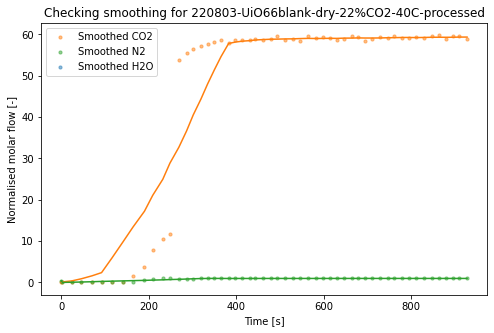

In [16]:
if plot_smoothing ==True:
    df_plot = pd.read_csv(filelabel + '.csv')
    plt.rcParams.update({'font.size': 10})
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(df_plot['Breakthrough time [s]'], df_plot['Normalised CO2 molar flow [mol/s]'], color='tab:orange', s=10, alpha=0.5)
    ax.scatter(df_plot['Breakthrough time [s]'], df_plot['Normalised N2 molar flow [mol/s]'], color='tab:green', s=10, alpha=0.5)
    ax.scatter(df_plot['Breakthrough time [s]'], df_plot['Normalised H2O molar flow [mol/s]'], color='tab:blue', s=10, alpha=0.5)
    ax.plot(df_plot['Breakthrough time [s]'], df_plot['Smoothed Normalised CO2 molar flow [mol/s]'], color='tab:orange', linestyle='-')
    ax.plot(df_plot['Breakthrough time [s]'], df_plot['Smoothed Normalised N2 molar flow [mol/s]'], color='tab:green', linestyle='-')
    ax.plot(df_plot['Breakthrough time [s]'], df_plot['Smoothed Normalised H2O molar flow [mol/s]'], color='tab:blue', linestyle='-')
    ax.legend(['Smoothed CO2', 'Smoothed N2', 'Smoothed H2O'])
    ax.set(xlabel='Time [s]', ylabel=('Normalised molar flow [-]'))
    ax.set_title('Checking smoothing for ' + filelabel)
    plt.show()


# Overview - what's next for this file

Graphs generated seem to be very bad so far - possibly due to normalisation or previous data handling 

Examine the smoothing further. Don't exactly know how it's done

Nitrogen seems to be extremely low - due to all of the mole fraction calculations possibly 

Smoothing has effect on graph of completely removing adsorption curve effectively (evidenced by plotting smoothed line vs unsmoothed line). This is quite important as susanna said the curve was one the key features to get.